# Etape 7 — Machine Learning

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Préparation initiale

In [51]:
df = pd.read_csv('DataFrame_Complet.csv')

In [52]:
ml_df = df.dropna(subset=['CVSS_score', 'Base_severity']).copy()

In [53]:
for col in ['EPSS_score', 'EPSS_percentile']:
    ml_df[col] = ml_df[col].fillna(0)

#### Correction ValueError: The least populated class in y has only 1 member, which is too few

In [55]:
ml_df = ml_df[ml_df['Base_severity'] != 'NONE'].copy()

## Apprentissage supervisé

In [57]:
print("\n--- Début de l'apprentissage supervisé ---")

le = LabelEncoder()
ml_df['Base_severity_encoded'] = le.fit_transform(ml_df['Base_severity'])


--- Début de l'apprentissage supervisé ---


In [58]:
X = ml_df[['CVSS_score', 'EPSS_score', 'EPSS_percentile']]
y = ml_df['Base_severity_encoded']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

Taille de l'ensemble d'entraînement : 4419
Taille de l'ensemble de test : 1895


In [60]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
y_pred = clf.predict(X_test)

In [62]:
# Rapport de classification
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
target_names = le.inverse_transform(unique_labels)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=target_names, labels=unique_labels))


Rapport de classification :
              precision    recall  f1-score   support

    CRITICAL       1.00      0.99      1.00       182
        HIGH       1.00      1.00      1.00      1076
         LOW       1.00      1.00      1.00        23
      MEDIUM       1.00      1.00      1.00       614

    accuracy                           1.00      1895
   macro avg       1.00      1.00      1.00      1895
weighted avg       1.00      1.00      1.00      1895



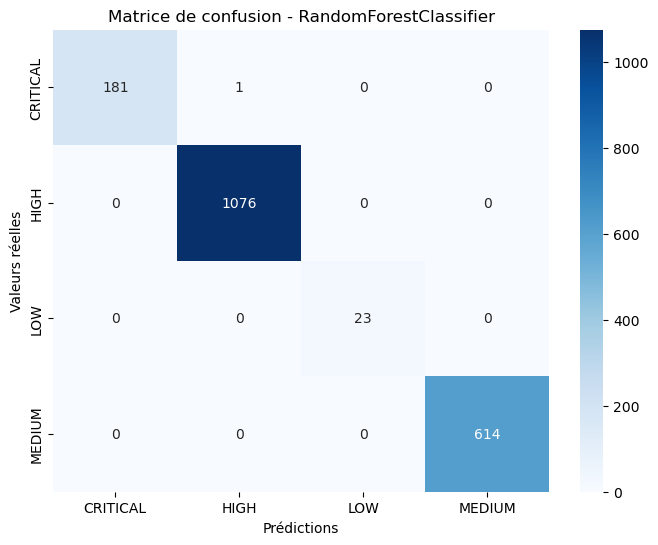

0.9994722955145119

In [96]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de confusion - RandomForestClassifier')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# View accuracy score
accuracy_score(y_test, y_pred)

#

# Interprétation - Random Forest

- Les valeurs sur la diagonale sont très élevées et les valeurs hors diagonale sont extrêmement faibles (voire nulles). Cela indique que le modèle RandomForestClassifier est exceptionnellement précis pour classer les vulnérabilités dans leurs catégories de gravité respectives (CRITICAL, HIGH, LOW, MEDIUM).
- Il n'y a qu'une seule instance mal classée visible dans cette matrice (un "HIGH" classé comme "CRITICAL").
- La matrice de confusion démontre que le RandomForestClassifier performe de manière exceptionnelle dans la classification des vulnérabilités selon leur gravité (CRITICAL, HIGH, LOW, MEDIUM)
_____
- Le score d'accuracy représente probablement l'exactitude globale du modèle, qui est d'environ 99.95%. C'est un score remarquablement élevé, suggérant que le modèle effectue des prédictions quasi parfaites sur cet ensemble de données.

## Apprentissage non supervisé

In [65]:
print("\n--- Début de l'apprentissage non supervisé ---")

features_for_clustering = ml_df[['CVSS_score', 'EPSS_score', 'EPSS_percentile']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)


--- Début de l'apprentissage non supervisé ---


In [66]:
# Application de K-Means pour trouver 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ml_df['cluster'] = kmeans.fit_predict(X_scaled)

In [67]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=['CVSS_score', 'EPSS_score', 'EPSS_percentile'])
print("\nCaractéristiques moyennes des clusters :")
print(centers_df)


Caractéristiques moyennes des clusters :
   CVSS_score  EPSS_score  EPSS_percentile
0    8.731111    0.621832         0.974871
1    7.899966    0.001377         0.193598
2    5.453697    0.001527         0.214827


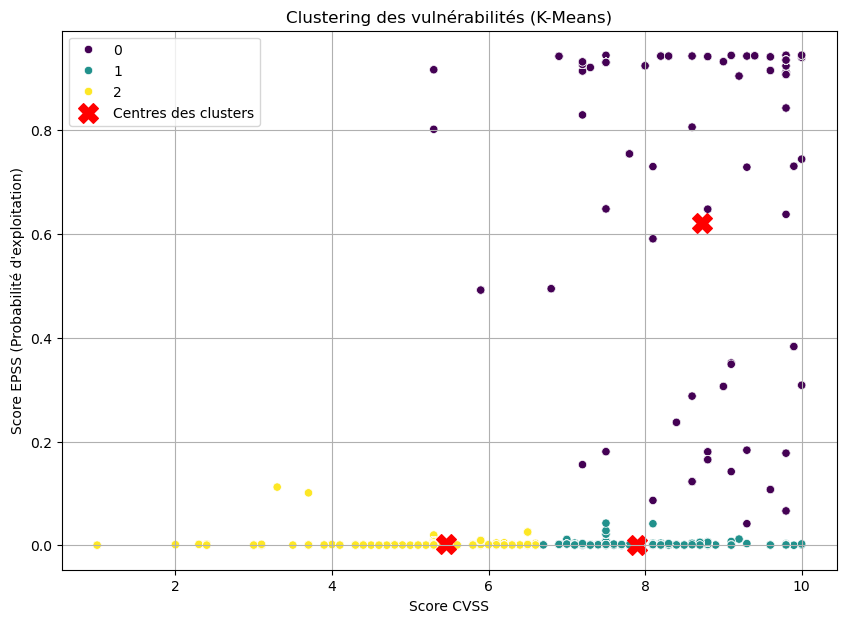


Score Silhouette : 0.554


In [68]:
from sklearn.metrics import silhouette_score

plt.figure(figsize=(10, 7))
sns.scatterplot(data=ml_df, x='CVSS_score', y='EPSS_score', hue='cluster', palette='viridis', legend='full')
plt.scatter(centers_df['CVSS_score'], centers_df['EPSS_score'], s=200, c='red', marker='X', label='Centres des clusters')
plt.title('Clustering des vulnérabilités (K-Means)')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS (Probabilité d\'exploitation)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, ml_df['cluster'])
print(f"\nScore Silhouette : {silhouette_avg:.3f}")

# Interprétation K-Means clustering

It indicates that the clusters are reasonably well-separated and that data points within each cluster are relatively cohesive.
While not exceptionally high (a score closer to 0.7 or 0.8 would indicate very strong, distinct clusters), it's significantly above 0 and far from negative, suggesting that the K-Means algorithm has found a sensible partitioning of your vulnerability data.
This score aligns with the visual inspection of the graph, where the clusters, while having some density variation, are largely distinguishable.

The scatter plot displays vulnerabilities clustered into three groups (0, 1, 2) based on Score CVSS (X-axis) and Score EPSS (Probabilité d'exploitation) (Y-axis). The red 'X' markers indicate the cluster centroids.

- Cluster 0 (Dark Purple/Blue Dots): These vulnerabilities generally have lower CVSS_score values (ranging from approximately 3 to 6) and very low EPSS_score values (mostly at or near 0).
his cluster represents "Low Risk, Low Exploitability" vulnerabilities. They have lower severity and are very unlikely to be exploited.
- Cluster 1 (Teal/Green Dots): This cluster is characterized by higher CVSS_score values (ranging from approximately 6.5 to 10) and relatively high EPSS_score values (ranging from about 0.5 to 0.9+).
Interpretation: This cluster likely represents "High Risk, High Exploitability" vulnerabilities. These are critical issues with high severity and a significant probability of being exploited. 
This group would typically require immediate attention.
- Cluster 2 (Yellow Dots): These vulnerabilities primarily have higher CVSS_score values (similar range to Cluster 1, from ~7 to 10) but very low EPSS_score values (mostly between 0 and 0.3). 
There's a notable concentration of these points at low EPSS scores despite higher CVSS scores.
Interpretation: This cluster could represent "High Risk, Low Exploitability" vulnerabilities. While their CVSS scores indicate high severity, their low EPSS scores suggest they are less likely to be exploited in practice. 
This distinction is very useful, as it helps prioritize which high-CVSS vulnerabilities to focus on first (those in Cluster 1).

- Cluster Separation and Overlap:

Clusters 0 and 1 appear to be relatively well-separated, especially along the Y-axis (EPSS score).
There is some horizontal overlap in CVSS_score between Cluster 1 and Cluster 2, particularly in the higher CVSS range. However, they are clearly separated by their EPSS_score, which is the key differentiator here. 
This indicates that the clustering effectively leverages both dimensions to create meaningful groups.
The centroids are located appropriately within their respective clusters.
                                                                                                                                                                                                                                                                                                                                         
2. For our K-means, we got a silhouette Score of 0.554. A score of 0.554 is generally considered a moderately good result for clustering. It indicates that the clusters are reasonably well-separated and that data points within each cluster are relatively cohesive.
While not exceptionally high, it's significantly above 0 and far from negative, suggesting that the K-Means algorithm has found a sensible partitioning of your vulnerability data.
This score aligns with the visual inspection of the graph, where the clusters, while having some density variation, are largely distinguishable.

Conclusion:
Our K-Means clustering, with 3 clusters, has successfully segmented vulnerabilities into distinct and interpretable groups based on their CVSS and EPSS scores.

We identified at least three profiles:
Low Risk/Low Exploitability (Cluster 0)
High Risk/High Exploitability (Cluster 1)
High Risk/Low Exploitability (Cluster 2)
The Silhouette Score of 0.536 supports the validity of these clusters, indicating a good level of separation and cohesion.